In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

def dbPath() -> Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    db = dc2.joinpath("data/database_final.db")
    return db
def modelPath(lsoaCode:str) ->Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    modelPath = dc2.joinpath(f"data/models/{lsoaCode}.bin")
    return modelPath


conn = sqlite3.connect(dbPath())
query_lsoa_codes = "SELECT geogcode FROM lsoa_code_to_name"
lsoa_codes = pd.read_sql(query_lsoa_codes, conn)

query_unemployement = "SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"
unemployement = pd.read_sql(query_unemployement, conn)

unemployement.dropna(inplace=True)
unemployement.drop(columns="index", inplace=True)
unemployement = unemployement[(unemployement["date"]<"2020") & (unemployement["date"]>"2012")]

unemployement = unemployement[unemployement["geogcode"]!="Column Total"].copy()
lsoa_code_list = lsoa_codes[lsoa_codes["geogcode"] != "Column Total"]["geogcode"].to_list()
allFeatures = pd.DataFrame(columns=lsoa_code_list, index=unemployement["date"].unique())

for row in tqdm(unemployement.index):
    allFeatures[unemployement["geogcode"][row]][unemployement["date"][row]] = unemployement["value"][row]

for code in tqdm(lsoa_code_list):
    for i in range(12):
        allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)

allFeatures = allFeatures.dropna()

code_out_shift = allFeatures[lsoa_code_list].copy()
code_with_shift = allFeatures.drop(lsoa_code_list, axis=True).copy()

  0%|          | 0/17724 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

/tmp/ipykernel_13912/1879651263.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)
/tmp/ipykernel_13912/1879651263.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)
/tmp/ipykernel_13912/1879651263.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [2]:
code_with_shift.head()

,E01000115_shift_1,E01000115_shift_2,E01000115_shift_3,E01000115_shift_4,E01000115_shift_5,E01000115_shift_6,E01000115_shift_7,E01000115_shift_8,E01000115_shift_9,E01000115_shift_10,...,E01033573_shift_3,E01033573_shift_4,E01033573_shift_5,E01033573_shift_6,E01033573_shift_7,E01033573_shift_8,E01033573_shift_9,E01033573_shift_10,E01033573_shift_11,E01033573_shift_12
2014-01-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,10.0,10.0,...,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0,25.0
2014-02-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,10.0,...,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0
2014-03-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,15.0,...,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0
2014-04-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,...,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0
2014-05-01 00:00:00,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,25.0,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0


In [14]:

modelDct = {}
metrics = {
}
for col in tqdm(lsoa_code_list):
    y = code_out_shift[col].copy()
    x = code_with_shift.copy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model = xgb.XGBRegressor()
    model.fit(X_train.values, y_train) 
    y_pred = model.predict(X_test.values)
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    medae_test = median_absolute_error(y_test, y_pred)
    metrics[col] = [mse_test, mae_test, r2_test, medae_test]
    model.save_model(modelPath(col))


  0%|          | 0/211 [00:00<?, ?it/s]

In [19]:
metricsDF = pd.DataFrame(metrics)

metricsDF = metricsDF.T
metricsDF.columns = ["MSE", "MAE", "R^2", "MedAE"]
stats = metricsDF.describe()
stats = stats.T
out = stats["mean"]
out.rename(columns)

MSE      12.523413
MAE       2.552307
R^2       0.480171
MedAE     2.024083
Name: mean, dtype: float64

In [21]:
diff = sum((y_pred - y_test.values)**2)
sst = sum((y_test - np.mean(y_test))**2)

# 1 -(diff/sst)


83.33333333333333

In [17]:
# X_train

In [18]:
# fig, ax = plt.subplots()

# ax.plot(y_train.index, y_train)
# ax.plot(y_test.index, y_test)
# ax.plot(y_test.index, y_pred)


In [19]:
# max_key = max(metrics, key=lambda k: metrics[k][0])

In [44]:
min_key = max(metrics, key=lambda k: metrics[k][2])
min_key
model = xgb.XGBRegressor()
xgb.load_model(modelPath(min_key))


'E01000126'

In [20]:
# allFeatures.reset_index(inplace=True)
# allFeatures = allFeatures.rename(columns={"index":"date"})

In [21]:
# code_out_shift = allFeatures[lsoa_code_list].copy()
# code_with_shift = allFeatures.drop(lsoa_code_list, axis=True).copy()

In [22]:
# columns = ["target_value", "target_code"] + list(code_with_shift.columns)

# ls = []
# for code in tqdm(iter(code_out_shift.columns)):
#     temp = code_with_shift.copy()
#     temp["target_code"] = code
#     temp["target_value"] = code_out_shift[code]
#     temp.reset_index(inplace=True)
#     ls.append(temp)

# final = pd.concat(ls)
# final = final.rename(columns={"index":"date"})
# encoded_LSOA = pd.get_dummies(final["target_code"], prefix="is")
# finalEncoded = pd.concat([final, encoded_LSOA], axis=1)

In [23]:
# finalEncoded

In [24]:
# model = xgb.XGBRegressor()
# x = finalEncoded.drop(columns = ["target_value", "target_code", "date"]).copy()
# y = finalEncoded[["target_value", "target_code", "date"]].copy()


In [25]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# model = xgb.XGBRegressor()
# model.fit(X_train.values, y_train["target_value"].values)

# pred_train = model.predict(X_train.values)
# predictions = model.predict(X_test.values)

# mse_train = mean_squared_error(y_train["target_value"].values, pred_train)
# mae_train = mean_absolute_error(y_train["target_value"].values, pred_train)
# r2_train = r2_score(y_train["target_value"].values, pred_train)
# medae_train = median_absolute_error(y_train["target_value"].values, pred_train)

# # Calculate the test performance metrics
# mse_test = mean_squared_error(y_test["target_value"].values, predictions)
# mae_test = mean_absolute_error(y_test["target_value"].values, predictions)
# r2_test = r2_score(y_test["target_value"].values, predictions)
# medae_test = median_absolute_error(y_test["target_value"].values, predictions)

# # Create a dictionary with the train and test metric names and values
# metrics = {
#     'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
#     'Train Value': [mse_train, mae_train, r2_train, medae_train],
#     'Test Value': [mse_test, mae_test, r2_test, medae_test]
# }

In [26]:
# metricsDF = pd.DataFrame(metrics)
# metricsDF

In [27]:
# y_test = y_test.reset_index(drop=True)
# # y_test = y_test.drop("index")
# y_test

In [28]:
# preDF = pd.DataFrame({"Pred":predictions})
# preDF

In [30]:

# y_test = y_test.join(preDF)

In [29]:
# for lsoa in lsoa_code_list:
#     temp = y_test[y_test["target_code"] == lsoa]
#     break
# temp

In [31]:
# fig, ax = plt.subplots()
# ax.plot(temp["date"], temp["target_value"])
# ax.plot(temp["date"], temp["Pred"])

In [39]:
by_metric = {'MSE':[], 'MAE':[], 'R^2':[], "MedAE":[]}
comb = {"metric":[], "value":[]}
for val in metrics.values():
    by_metric["MSE"].append(val[0])
    by_metric["MAE"].append(val[1])
    by_metric["R^2"].append(val[2])
    by_metric["MedAE"].append(val[3])

    comb["metric"].append("MAE")
    comb["value"].append(val[1])
    comb["metric"].append("R^2")
    comb["value"].append(val[2])
    comb["metric"].append("MedAE")
    comb["value"].append(val[3])
    

comDF = pd.DataFrame(comb)

In [40]:
comDF

,metric,value
0,MAE,2.023356
1,R^2,0.196029
2,MedAE,1.198997
3,MAE,2.109294
4,R^2,0.343445
...,...,...
628,R^2,-0.058907
629,MedAE,3.916716
630,MAE,2.182338
631,R^2,0.846104


<Axes: xlabel='metric', ylabel='value'>

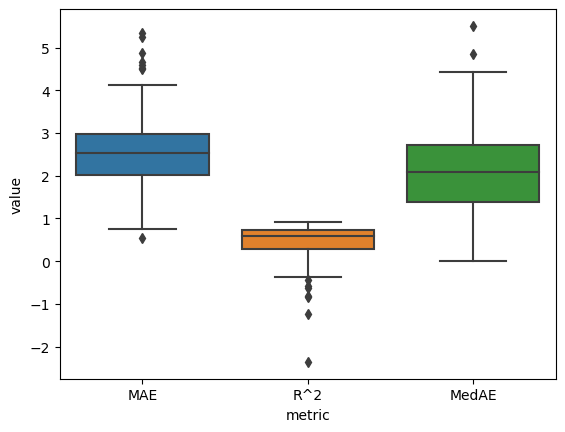

In [43]:
import seaborn as sns
sns.boxplot(comDF, x="metric", y="value")

In [ ]:
metricDF = pd.DataFrame(by_metric)

In [ ]:
sns.boxlot(data=metricDF["R^2"])

In [ ]:
sns.boxplot(data=metricDF["MSE"])


In [136]:
sns.boxplot()